In [85]:
from urllib.request import urlopen
import json
import pandas as pd
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

# 1) Which driver has been slowest compared to their team-mate

## Get meets

In [86]:
def get_meets(req):
    
    response = urlopen(f'https://api.openf1.org/v1/{req}')
    data = json.loads(response.read().decode('utf-8'))
    
    cols=['meeting_key','meeting_name','date_start']
    df = pd.DataFrame(data)    
    df = df[cols]
    
    # Format date
    df["date_start"] = pd.to_datetime(df["date_start"]).dt.strftime("%d-%m-%Y")
    
    return df

meets=get_meets('meetings?year=2025')
meets_keys = meets['meeting_key'].unique()


In [89]:
meets.tail()

,meeting_key,meeting_name,date_start
12,1277,British Grand Prix,04-07-2025
13,1265,Belgian Grand Prix,25-07-2025
14,1266,Hungarian Grand Prix,01-08-2025
15,1267,Dutch Grand Prix,29-08-2025
16,1268,Italian Grand Prix,05-09-2025


## Get driver qualifying performance

date_start, meeting_key, circuit_short_name, driver_key, driver_team, driver_name, q1_best, q2_best, q3_best

In [91]:
def get_drivers(req):
    
    response = urlopen(f'https://api.openf1.org/v1/{req}')
    data = json.loads(response.read().decode('utf-8'))
    
    cols=['meeting_key','session_key','driver_number' ,'full_name', 'team_name']
    df = pd.DataFrame(data)        
    df = df[cols]
        
    return df

In [93]:
# Get all drivers historically
drivers=get_drivers(req='drivers')

# Filter to only races this year
drivers = drivers[drivers["meeting_key"].isin(meets_keys)]

# Left join races onto drivers
metrics_df = drivers.merge(
    meets,
    how="left",          # ensures left join
    on="meeting_key"      # column name(s) to join on
)

In [95]:
# Join in sessions data
def get_session_names(req):
    
    response = urlopen(f'https://api.openf1.org/v1/{req}')

    data = json.loads(response.read().decode('utf-8'))
    
    cols=['session_key','session_type']
    df = pd.DataFrame(data)        
    df = df[cols]
        
    return df

session_names=get_session_names(req='sessions')


# Filter to only races this year
session_keys=drivers['session_key'].unique()
session_names = session_names[session_names["session_key"].isin(session_keys)]

# Left join races onto drivers
metrics_df = metrics_df.merge(
    session_names,
    how="left",          # ensures left join
    on="session_key"      # column name(s) to join on
)

In [97]:
def get_session_results(req):
    
    response = urlopen(f'https://api.openf1.org/v1/{req}')
    data = json.loads(response.read().decode('utf-8'))
    
    cols=['meeting_key','session_key','driver_number', 'position','number_of_laps','dnf', 'duration','points']
    df = pd.DataFrame(data)    
    df = df[cols]
        
    return df

session_results=get_session_results(req='session_result')

In [100]:
# Filter to only races this year
session_keys = metrics_df['session_key'].unique()
session_results = session_results[session_results["session_key"].isin(session_keys)]

# Left join races onto drivers
metrics_df = metrics_df.merge(
    session_results,
    how="left",          # ensures left join
    on=["session_key", "driver_number"]   # join on both columns
)

metrics_df = metrics_df[metrics_df["meeting_name"] != "Pre-Season Testing"]

In [101]:
metrics_df.head(5)

,meeting_key_x,session_key,driver_number,full_name,team_name,meeting_name,date_start,session_type,meeting_key_y,position,number_of_laps,dnf,duration,points
56,1254,9686,1,Max VERSTAPPEN,Red Bull Racing,Australian Grand Prix,14-03-2025,Practice,1254.0,5.0,21.0,False,77.696,NaN
57,1254,9686,4,Lando NORRIS,McLaren,Australian Grand Prix,14-03-2025,Practice,1254.0,1.0,21.0,False,77.252,NaN
58,1254,9686,5,Gabriel BORTOLETO,Kick Sauber,Australian Grand Prix,14-03-2025,Practice,1254.0,15.0,22.0,False,78.438,NaN
59,1254,9686,6,Isack HADJAR,Racing Bulls,Australian Grand Prix,14-03-2025,Practice,1254.0,9.0,25.0,False,77.847,NaN
60,1254,9686,7,Jack DOOHAN,Alpine,Australian Grand Prix,14-03-2025,Practice,1254.0,13.0,20.0,False,78.232,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1660,1277,9947,44,Lewis HAMILTON,Ferrari,British Grand Prix,04-07-2025,Race,1277.0,4.0,52.0,False,5875.547,12.0
1661,1277,9947,55,Carlos SAINZ,Williams,British Grand Prix,04-07-2025,Race,1277.0,12.0,52.0,False,5912.327,0.0
1662,1277,9947,63,George RUSSELL,Mercedes,British Grand Prix,04-07-2025,Race,1277.0,10.0,52.0,False,5906.409,1.0
1663,1277,9947,81,Oscar PIASTRI,McLaren,British Grand Prix,04-07-2025,Race,1277.0,2.0,52.0,False,5842.547,18.0


# Final Preprocessing

In [103]:
# Change meeting key names
metrics_df = metrics_df.drop(columns=["meeting_key_y"]).rename(columns={"meeting_key_x": "meeting_key"})
metrics_df["full_name"] = metrics_df["full_name"].replace("Andrea Kimi ANTONELLI", "Kimi ANTONELLI")

# Insights

## 0. Preprocessing

In [105]:
# Split into a race and qualy df
race_df=metrics_df[metrics_df['session_type']=='Race'].reset_index(drop=True)
qualy_df=metrics_df[metrics_df['session_type']=='Qualifying'].reset_index(drop=True)

In [106]:
# Q1/2/3 visits
def expand_quali_durations(df, drop_source=True):

    out = df.copy()
    out["q1_best_time"] = out["duration"].str[0].fillna(False)
    out["q2_best_time"] = out["duration"].str[1].fillna(False)
    out["q3_best_time"] = out["duration"].str[2].fillna(False)
    if drop_source:
        out = out.drop(columns=["duration", 'points'])
    return out
qualy_df=expand_quali_durations(qualy_df)

In [107]:
# Replace all pit starts with 20
qualy_df["position"] = qualy_df["position"].fillna(20)

## 1. Qualifying

In [108]:
qualy_df.head()

,meeting_key,session_key,driver_number,full_name,team_name,meeting_name,date_start,session_type,position,number_of_laps,dnf,q1_best_time,q2_best_time,q3_best_time
0,1254,9689,1,Max VERSTAPPEN,Red Bull Racing,Australian Grand Prix,14-03-2025,Qualifying,3.0,17.0,False,76.018,75.565,75.481
1,1254,9689,4,Lando NORRIS,McLaren,Australian Grand Prix,14-03-2025,Qualifying,1.0,20.0,False,75.912,75.415,75.096
2,1254,9689,5,Gabriel BORTOLETO,Kick Sauber,Australian Grand Prix,14-03-2025,Qualifying,15.0,13.0,False,76.516,77.52,False
3,1254,9689,6,Isack HADJAR,Racing Bulls,Australian Grand Prix,14-03-2025,Qualifying,11.0,12.0,False,76.354,76.175,False
4,1254,9689,7,Jack DOOHAN,Alpine,Australian Grand Prix,14-03-2025,Qualifying,14.0,15.0,False,76.315,76.863,False


In [110]:
# 1. Average qualifying position by driver
def avg_qualifying_position(df):
    result = (
        df.groupby(['full_name','team_name'])['position']
          .mean()
          .round(1)
          .sort_values()
          .reset_index()
    )
    return result


avg_qualifying_position(qualy_df)

,full_name,team_name,position
0,Oscar PIASTRI,McLaren,2.1
1,Max VERSTAPPEN,Red Bull Racing,3.2
2,Lando NORRIS,McLaren,3.3
3,Charles LECLERC,Ferrari,5.1
4,George RUSSELL,Mercedes,5.1
5,Yuki TSUNODA,Racing Bulls,7.3
6,Lewis HAMILTON,Ferrari,7.9
7,Kimi ANTONELLI,Mercedes,9.2
8,Isack HADJAR,Racing Bulls,10.1
9,Fernando ALONSO,Aston Martin,10.9


In [111]:
# 2. Qualifying disparity by team
def teammate_position_diffs_unique(df):

    records = []

    # Loop through each team and session
    for (team, session), group in df.groupby(['team_name','session_key']):
        drivers = group[['full_name','position']]

        for (d1, p1), (d2, p2) in combinations(drivers.values, 2):
            diff = p1 - p2
            records.append((team, d1, d2, diff))
            records.append((team, d2, d1, -diff))  # both orientations

    pair_df = pd.DataFrame(records, columns=['team_name','driver_1','driver_2','diff'])

    result = (
        pair_df.groupby(['team_name','driver_1','driver_2'])
               .agg(number_sessions=('diff','count'),
                    average_difference=('diff','mean'))
               .reset_index()
    )
    result['average_difference'] = result['average_difference'].round(1)

    # Unique unordered pair key
    result['pair_key'] = result.apply(lambda x: tuple(sorted([x['driver_1'], x['driver_2']])), axis=1)

    # Keep row with max avg diff per pair
    result = result.loc[result.groupby(['team_name','pair_key'])['average_difference'].idxmax()]

    # 🔄 Swap driver_1 and driver_2
    result[['driver_1','driver_2']] = result[['driver_2','driver_1']]

    # Clean + sort
    result = result.drop(columns='pair_key').sort_values('average_difference', ascending=False).reset_index(drop=True)

    return result


qualy_disp=teammate_position_diffs_unique(qualy_df)
qualy_disp[qualy_disp['number_sessions']>=5]

,team_name,driver_1,driver_2,number_sessions,average_difference
1,Red Bull Racing,Max VERSTAPPEN,Yuki TSUNODA,16,9.9
2,Aston Martin,Fernando ALONSO,Lance STROLL,19,4.8
3,Mercedes,George RUSSELL,Kimi ANTONELLI,19,4.2
5,Alpine,Pierre GASLY,Jack DOOHAN,8,3.5
6,Alpine,Pierre GASLY,Franco COLAPINTO,11,3.4
7,Racing Bulls,Isack HADJAR,Liam LAWSON,16,3.1
8,Ferrari,Charles LECLERC,Lewis HAMILTON,19,2.8
9,Kick Sauber,Gabriel BORTOLETO,Nico HULKENBERG,19,1.9
10,McLaren,Oscar PIASTRI,Lando NORRIS,19,1.2
11,Williams,Alexander ALBON,Carlos SAINZ,19,0.7


In [112]:
# 3. Differences discounting Crashes
def teammate_position_diffs_unique_no_crash(df):
    records = []

    # Loop through each team and session
    for (team, session), group in df.groupby(['team_name','session_key']):
        # 🚫 Skip this session if ANY driver in the team DNF'd
        if group['dnf'].any():
            continue

        drivers = group[['full_name','position']]

        # All unordered pairs in this team/session
        for (d1, p1), (d2, p2) in combinations(drivers.values, 2):
            diff = p1 - p2
            records.append((team, d1, d2, diff))
            records.append((team, d2, d1, -diff))  # both orientations

    # Build DataFrame
    pair_df = pd.DataFrame(records, columns=['team_name','driver_1','driver_2','diff'])

    result = (
        pair_df.groupby(['team_name','driver_1','driver_2'])
               .agg(number_sessions=('diff','count'),
                    average_difference=('diff','mean'))
               .reset_index()
    )
    result['average_difference'] = result['average_difference'].round(1)

    # Unique unordered pair key
    result['pair_key'] = result.apply(
        lambda x: tuple(sorted([x['driver_1'], x['driver_2']])), axis=1
    )

    # Keep row with max avg diff per pair
    result = result.loc[
        result.groupby(['team_name','pair_key'])['average_difference'].idxmax()
    ]

    # 🔄 Swap driver_1 and driver_2
    result[['driver_1','driver_2']] = result[['driver_2','driver_1']]

    # Clean + sort
    result = (
        result.drop(columns='pair_key')
              .sort_values('average_difference', ascending=False)
              .reset_index(drop=True)
    )

    return result

qualy_disp_no_crash=teammate_position_diffs_unique_no_crash(qualy_df)
qualy_disp_no_crash[qualy_disp_no_crash['number_sessions']>=5]

,team_name,driver_1,driver_2,number_sessions,average_difference
1,Red Bull Racing,Max VERSTAPPEN,Yuki TSUNODA,15,9.4
2,Aston Martin,Fernando ALONSO,Lance STROLL,18,4.5
3,Mercedes,George RUSSELL,Kimi ANTONELLI,18,4.3
4,Alpine,Pierre GASLY,Jack DOOHAN,8,3.5
5,Alpine,Pierre GASLY,Franco COLAPINTO,11,3.4
6,Racing Bulls,Isack HADJAR,Liam LAWSON,16,3.1
7,Ferrari,Charles LECLERC,Lewis HAMILTON,19,2.8
9,Kick Sauber,Gabriel BORTOLETO,Nico HULKENBERG,19,1.9
10,McLaren,Oscar PIASTRI,Lando NORRIS,18,0.8
11,Williams,Alexander ALBON,Carlos SAINZ,18,0.4


In [113]:
# 4. Statistically the best qualifying lap all season
def add_fastest_qualy_lap(df):
    # Ensure q1/q2/q3 are numeric and replace False with NaN
    q_times = (
        df[['q1_best_time','q2_best_time','q3_best_time']]
        .replace(False, np.nan)
        .apply(pd.to_numeric, errors='coerce')
    )

    # Take row-wise min, ignoring NaN
    df['fastest_qualy_lap'] = q_times.min(axis=1, skipna=True)

    # Keep required cols
    df_out = df[['meeting_key','session_key','driver_number','full_name',
                 'team_name','meeting_name','session_type','q1_best_time','q2_best_time','q3_best_time','fastest_qualy_lap', 'position']]
    
    # 🚫 Drop rows where fastest_qualy_lap is NaN
    df_out = df_out.dropna(subset=['fastest_qualy_lap'])
    
    # Sort by session then fastest lap
    df_out = df_out.sort_values(['session_key','fastest_qualy_lap'], ascending=[True, True]).reset_index(drop=True)

    return df_out

def add_gap_and_median(df):
    # Work on a copy
    df = df.copy()

    def process_session(group):
        # Sort within session
        group = group.sort_values('fastest_qualy_lap').reset_index(drop=True)

        # Gap to driver below
        group['gap_to_below'] = group['fastest_qualy_lap'].shift(-1) - group['fastest_qualy_lap']

        # Drop driver 1's gap + last driver NaN when calculating median
        gaps_for_median = group['gap_to_below'].iloc[1:-1]

        # Median of these gaps
        median_gap = gaps_for_median.median()

        # Assign same median to all rows in this session
        group['median_time_difference'] = median_gap

        return group

    # Apply to each session
    df = df.groupby('session_key', group_keys=False).apply(process_session)

    return df

def leader_gap_ratio(df):
    # Ensure we're not modifying the input
    df = df.copy()

    results = []

    for session_key, group in df.groupby('session_key'):
        # Get fastest driver (position 1 or smallest lap time)
        leader = group.loc[group['fastest_qualy_lap'].idxmin()]

        # Calculate ratio
        if pd.notna(leader['gap_to_below']) and pd.notna(leader['median_time_difference']) and leader['median_time_difference'] != 0:
            ratiod_time = leader['gap_to_below'] / leader['median_time_difference']
        else:
            ratiod_time = np.nan

        # Collect relevant info
        results.append({
            'meeting_key': leader['meeting_key'],
            'session_key': leader['session_key'],
            'driver_number': leader['driver_number'],
            'full_name': leader['full_name'],
            'team_name': leader['team_name'],
            'meeting_name': leader['meeting_name'],
            'session_type': leader['session_type'],
            'fastest_qualy_lap': leader['fastest_qualy_lap'],
            'position': leader['position'],
            'gap_to_below': leader['gap_to_below'],
            'median_time_difference': leader['median_time_difference'],
            'ratiod_time': ratiod_time
        })

    # Build DataFrame
    result_df = pd.DataFrame(results)

    # Sort by ratio descending
    result_df = result_df.sort_values('ratiod_time', ascending=False).reset_index(drop=True)

    return result_df


In [114]:
qualy_fastest_lap=add_fastest_qualy_lap(qualy_df)
qualy_fastest_lap=add_gap_and_median(qualy_fastest_lap)
leader_gap_df=leader_gap_ratio(qualy_fastest_lap)

/var/folders/z7/nqjyxg1n1p9073g7jsxhq8w80000gn/T/ipykernel_34629/3191469374.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace(False, np.nan)
/var/folders/z7/nqjyxg1n1p9073g7jsxhq8w80000gn/T/ipykernel_34629/3191469374.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('session_key', group_keys=False).apply(process_session)


In [115]:
leader_gap_df.head(5)

,meeting_key,session_key,driver_number,full_name,team_name,meeting_name,session_type,fastest_qualy_lap,position,gap_to_below,median_time_difference,ratiod_time
0,1264,9951,4,Lando NORRIS,McLaren,Austrian Grand Prix,Qualifying,63.971,1.0,0.521,0.0555,9.387387
1,1262,9967,81,Oscar PIASTRI,McLaren,Spanish Grand Prix,Qualifying,71.546,1.0,0.209,0.0595,3.512605
2,1265,9930,81,Oscar PIASTRI,McLaren,Belgian Grand Prix,Qualifying,100.510,1.0,0.477,0.1480,3.222973
3,1263,9959,63,George RUSSELL,Mercedes,Canadian Grand Prix,Qualifying,70.899,1.0,0.160,0.0605,2.644628
4,1257,10010,81,Oscar PIASTRI,McLaren,Bahrain Grand Prix,Qualifying,89.841,1.0,0.168,0.0910,1.846154
5,1277,9943,1,Max VERSTAPPEN,Red Bull Racing,British Grand Prix,Qualifying,84.892,1.0,0.103,0.0595,1.731092
6,1268,9908,1,Max VERSTAPPEN,Red Bull Racing,Italian Grand Prix,Qualifying,78.792,1.0,0.077,0.0535,1.439252
7,1255,9994,81,Oscar PIASTRI,McLaren,Chinese Grand Prix,Qualifying,90.641,1.0,0.082,0.0610,1.344262
8,1261,9975,4,Lando NORRIS,McLaren,Monaco Grand Prix,Qualifying,69.954,1.0,0.109,0.0830,1.313253
9,1254,9689,4,Lando NORRIS,McLaren,Australian Grand Prix,Qualifying,75.096,1.0,0.084,0.0650,1.292308


In [116]:
# 5. Which drivers are getting better?
def add_rolling_qualy_position(df, window=None):
    df = df.copy()
    df["date_start"] = pd.to_datetime(df["date_start"], format="%d-%m-%Y")
    df = df.sort_values("date_start", ascending=True)
    df["rolling_qualy_position"] = (
        df.groupby("driver_number")["position"]
          .transform(lambda x: x.expanding().mean().round(2))
    )
    return df

rolling_qualy_avg = add_rolling_qualy_position(qualy_df)

In [119]:
def pivot_rolling_positions(df):
    df = df.copy()
    df["date_start"] = pd.to_datetime(df["date_start"], format="%Y-%m-%d")

    # Ensure sorted order within driver
    df = df.sort_values(["driver_number", "date_start"])

    # Give each qualifying round an index per driver
    df["qualy_round"] = df.groupby("driver_number").cumcount() + 1

    # Pivot wider: one column per round
    wide = df.pivot_table(
        index=["driver_number", "full_name"],
        columns="qualy_round",
        values="rolling_qualy_position"
    ).reset_index()

    # Rename columns to qualy_X_ra
    wide.columns = [
        "driver_number" if c == "driver_number" else
        "driver_name" if c == "full_name" else
        f"qualy_{c}_ra"
        for c in wide.columns
    ]

    return wide

def add_qualy_improvement(df):
    df = df.copy()
    df["qualy_improvement"] = (df["qualy_10_ra"] - df["qualy_19_ra"]).round(2)
    return df.sort_values("qualy_improvement", ascending=False).reset_index(drop=True)


pivot_qualy=pivot_rolling_positions(rolling_qualy_avg)

# Shift Colapinto
pivot_qualy.loc[pivot_qualy['driver_name']=='Franco COLAPINTO', 'qualy_1_ra':] = pivot_qualy.loc[pivot_qualy['driver_name']=='Franco COLAPINTO', 'qualy_1_ra':].shift(8, axis=1)

# Build qualy improvement df
pivot_qualy_imp=add_qualy_improvement(pivot_qualy)
rename_map = {
    "qualy_10_ra": "race_10",
    "qualy_15_ra": "race_15",
    "qualy_19_ra": "race_19"
}

pivot_qualy_imp = pivot_qualy_imp.rename(columns=rename_map)

In [120]:
pivot_qualy_imp[['driver_name', 'race_10', 'race_15','race_19', 'qualy_improvement']]

,driver_name,race_10,race_15,race_19,qualy_improvement
0,Gabriel BORTOLETO,16.5,15.20,14.00,2.50
1,Oliver BEARMAN,17.0,15.27,14.84,2.16
2,Liam LAWSON,15.5,14.67,14.00,1.50
3,Franco COLAPINTO,17.5,17.00,16.73,0.77
4,Lando NORRIS,3.8,3.60,3.26,0.54
5,Fernando ALONSO,11.4,10.93,10.89,0.51
6,Charles LECLERC,5.5,5.47,5.05,0.45
7,Oscar PIASTRI,2.2,2.13,2.11,0.09
8,Esteban OCON,14.6,14.33,14.58,0.02
9,Isack HADJAR,10.1,10.27,10.11,-0.01


In [127]:
top_drivers=pivot_qualy_imp[['driver_name','race_10', 'race_15','race_19']].head(5)
bottom_drivers=pivot_qualy_imp[['driver_name','race_10', 'race_15','race_19']].tail(6)

In [142]:
def plot_driver_qualy(df, improving):
    import matplotlib.pyplot as plt
    
    session_cols = [col for col in df.columns if col != "driver_name"]
    placed_y = set()  # keep track of used y positions

    for _, row in df.iterrows():
        plt.plot(session_cols, row[session_cols], marker="o")

        y = row[session_cols].iloc[-1]
        # If this y already used, shift it a bit
        while y in placed_y:
            y += -.7  # adjust spacing as needed
        placed_y.add(y)

        plt.text(
            len(session_cols) - 1 + 0.1,
            y,
            row["driver_name"],
            va="center"
        )

    plt.xlabel("Qualifying Session")
    plt.ylabel("Qualifying Position")
    plt.title("5 Most Improved Drivers" if improving else "5 Drivers Getting Worse")
    plt.gca().invert_yaxis()

    plt.xlim(-0.2, len(session_cols) - 1 + 1)
    plt.tight_layout()
    plt.show()


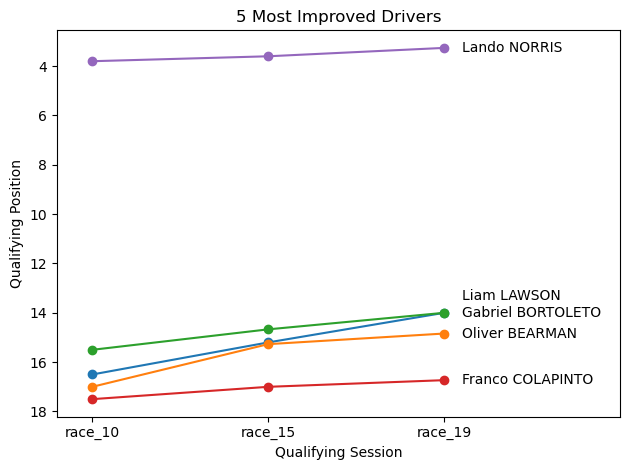

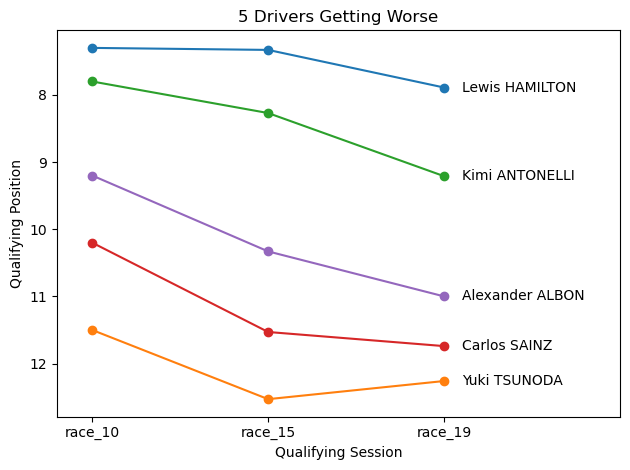

In [143]:
plot_driver_qualy(top_drivers, True)
plot_driver_qualy(bottom_drivers, False)